In [1]:
import os
import tqdm
import json

import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import defaultdict
from functools import  partial
from queue import PriorityQueue, Queue
import warnings
import heapq
from heapq import heappush, heappop

import torch
import sam2
from sam2.build_sam import build_sam2, build_sam2_hf
from sam2.sam2_image_predictor import SAM2ImagePredictor as SAM

import cv2
import numpy as np
from PIL import  Image
import scipy
import skimage

import FastGeodis as geo
import segmentationmetrics as segmetrics

In [2]:
segmetrics

<module 'segmentationmetrics' from '/work/hpc/miniconda3/envs/potato/lib/python3.10/site-packages/segmentationmetrics/__init__.py'>

In [3]:
import sys
print(sys.getrecursionlimit())
sys.setrecursionlimit(1000000000)

3000


# Inference preparation

In [4]:
sigmoid = lambda x: 1 / (1 + np.exp(-x))
gaussian = lambda x,mean,std: np.exp(-((x - mean) / std) ** 2 / 2) / (2.5 * std)

In [5]:
def get_bbox(bound, pt, patch_size):
    x = min(bound[1] - patch_size[1], max(0, pt[1] - patch_size[1] // 2))
    y = min(bound[0] - patch_size[0], max(0, pt[0] - patch_size[0] // 2))
    return x, y, patch_size[0], patch_size[1]

In [6]:
def valid_pts(pts, bbox):
    if isinstance(pts, list):
        pts = np.array(pts)
    if pts.shape[0] == 0:
        return pts
        
    pts -= bbox[:2][::-1]
    check = np.ones(pts.shape[0])
    for i in range(pts.shape[1]):
        check *= np.where((pts[:, i] > 0) & (pts[:, i] < bbox[i + 2]), 1, 0)
    return pts[np.where(check > 0)]

In [7]:
def compose_prompts(positive, negative):
    pos_label = np.ones(positive.shape[0])
    neg_label = np.zeros(negative.shape[0])
    if negative.shape[0] == 0:
        return positive[:, ::-1].copy(), pos_label
    pts = np.concatenate([positive, negative], axis=0)
    labels = np.concatenate((pos_label, neg_label))
    return pts[:, ::-1].copy(), labels

In [93]:
# A wrapper for Sam inference
class SamInferer:
    def __init__(self, cfg = "", 
                    ckpt: str = "",
                    model_id: str | None = None,
                    patch_size = [512, 512],
                    roi=[128, 128],
                    root_area=500,
                    max_roots=3,
                    patience = 5,
                    min_dis = 10,
                    back_off = 5,
                    alpha=0.1, 
                    d_alpha=0.2,
                    beta=0.5, 
                    post_act=True, 
                    min_length=5,
                    kernel_size=3,
                    fill_kernel_size=7,
                    neg_dis=15,
                    sampling_dis=3,
                    neg_sampling_grid=6,
                    thresh=0.75,
                    decay=0.5,
                    confidence=0.8,
                    topk=2,
                    stable_weight=3,
                    gamma=1
                    ):
        if model_id is None:
            self.predictor = SAM(build_sam2(cfg, ckpt))
        else: 
            self.predictor = SAM(build_sam2_hf(model_id))
        # Guidance and queries
        self.pos = np.zeros([0, 2], dtype=int)
        self.sampling_dis = sampling_dis
        self.marker = None
        self.hist = None
        self.patience = patience
        self.min_dis = min_dis
        self.stable_weight = stable_weight
        self.back_off = 5
        # self.queue = PriorityQueue()
        self.queue = []

        # Negative sampling
        self.neg = np.zeros([0, 2], dtype=int)
        self.neg_dis = neg_dis
        self.neg_sampling_grid = neg_sampling_grid
        # We gonna prioritize long flow over short ones
        self.root = None

        # Context related
        self.step = 0
        self.a_mask = None
        self.b_mask = None
        self.image = None 
        self.label = None
        self.alpha = alpha
        self.d_alpha = d_alpha
        self.beta = float(beta)
        self.confidence = confidence
        self.decay = decay
        self.post_act = post_act
        self.weight = None
        self.logits = None # Post-sigmoid or pre-sigmoid dependent
        self.var = None
        
        # kernel configuration
        self.patch_size = np.array(patch_size)
        self.w_kernel = [cv2.getGaussianKernel(patch_size[0], roi[0]), cv2.getGaussianKernel(patch_size[1], roi[1])]
        self.w_kernel = (self.w_kernel[0] / self.w_kernel[0][0, 0]) * (self.w_kernel[1] / self.w_kernel[1][0, 0]).T
        # self.w_kernel /= self.w_kernel.sum() 
        # TO prevent vanishing
        # self.w_kernel = np.interp(self.w_kernel, np.quantile(self.w_kernel, (0, 1)), (.2, 1))
        self.clahe = cv2.createCLAHE(clipLimit=2., tileGridSize=(51, 51))
        self.gamma = gamma
        
        # Uncertainty modelling
        kernel_size = (kernel_size, kernel_size) if isinstance(kernel_size, int) else kernel_size
        fill_kernel_size = (fill_kernel_size, fill_kernel_size) if isinstance(fill_kernel_size, int) else fill_kernel_size
        self.close_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size)
        self.fill_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, fill_kernel_size)
        self.stable_thresh = thresh
        
        # Flow skeleton
        self.atlas = None
        self.traits = None
        self.dis_map = None
        self.graph = defaultdict(list)
        self.min_length = min_length
        self.parent = dict()
        self.roi = None
        self.graph_root = np.zeros([0, 2], dtype=int)
        self.root_area = root_area
        self.max_roots = max_roots
        self.topk = topk

    # def pop(self):
    #     if self.queue.qsize() == 0:
    #         print("Empty queue !!!")
    #         return None
    #     score, item = self.queue.get()
    #     print(f"Candidate of score {score}")
    #     return item
    def pop(self):
        if len(self.queue) == 0:
            print("Empty queue !!!")
            return None
        (score, item) = self.queue.pop(0)
        print(f"Candidate of score {score}")
        return item
            
        
    def compose_prompts(self):
        def valid_pts(pts):
            pts -= self.root[None, :]
            check = np.ones(pts.shape[0])
            for i in range(pts.shape[1]):
                check *= np.where((pts[:, i] > 0) & (pts[:, i] < self.patch_size[i]), 1, 0)
            return pts[np.where(check > 0)]
        
        valid_pos = valid_pts(self.pos.copy())
        pos_label = np.ones(valid_pos.shape[0])
        if self.neg.shape[0] == 0:
            return valid_pos[:, ::-1].copy(), pos_label
        # Generated locally so no need for projection
        valid_neg = self.neg
        neg_label = np.zeros(valid_neg.shape[0])
        # Must be in xy format
        return np.concatenate([valid_pos, valid_neg], axis=0)[:, ::-1].copy(), np.concatenate([pos_label, neg_label], axis=0)

    def set_marker(self, mask): 
        self.marker = smooth_mask(mask, 15, 5.)
    
    def read(self, image_path, channels=3):
        img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
        
        if img.shape[-1] > channels: 
            self.label = img[..., channels]
        # Sharpen for better sense of boundary
        # hsv_image = cv2.cvtColor(img[..., :channels], cv2.COLOR_BGR2HSV_FULL)
        # unsharp = cv2.GaussianBlur(hsv_image, (3, 3), 0)
        # hsv_image = 2 * hsv_image - unsharp
        # self.image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB_FULL)
        self.image = img[..., :channels][..., ::-1]
        
        self.a_mask = np.zeros(self.image.shape[:2], dtype=np.uint8)
        self.b_mask = np.zeros(self.image.shape[:2], dtype=np.uint8)
        self.hist = np.zeros_like(self.b_mask)
        self.weight = np.full(self.image.shape[:2], 1e-6)
        self.logits = np.zeros(self.image.shape[:2]) if self.post_act else np.full(self.image.shape[:2], -10.) * self.weight
        self.var = np.zeros_like(self.logits)
        # self.beta = np.full(self.image.shape[:2], self.beta) * self.weight
        self.output = np.zeros_like(self.a_mask)
        self.box = self.image.shape[:2]

        self.atlas = np.zeros_like(self.b_mask)
        self.traits = np.zeros_like(self.b_mask)
        self.dis_map = np.zeros([img.shape[0], img.shape[1], 2], dtype=float)
    
    # Generate negative prior
    def negative_sampling(self, debug = False):
        # Prepare
        pts = (self.pos - self.root).round().astype(int)
        dst = self.root + self.patch_size
        a_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (self.neg_dis, self.neg_dis))
        grad_kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (5, 5))
        
        mask = self.b_mask[self.root[0]:dst[0], self.root[1]:dst[1]].copy()        
        gradient = cv2.morphologyEx(cv2.dilate(mask, a_kernel, iterations=5), cv2.MORPH_GRADIENT, grad_kernel)

        for pt in pts:
            cv2.circle(gradient, pt[::-1], self.neg_dis * 3, 0, -1)

        alpha_mask = scipy.ndimage.binary_fill_holes(self.a_mask[self.root[0]: dst[0], self.root[1]:dst[1]]).astype(int).astype(np.uint8)
        alpha_mask = cv2.dilate(alpha_mask,  a_kernel, 3)

        negative_field = gradient * (1 - alpha_mask)
        # Discretize to 5 bin
        output = grid_sampling(negative_field.astype(float), grid=self.neg_sampling_grid, alpha=0.01)
        dis = np.triu(np.linalg.norm(output[None, :] - output[:, None, :], axis=2))
        dis[dis == 0] = 1e5
        drop = np.where(dis < self.neg_dis)[0]
        accepted_neg = [i for i in range(output.shape[0]) if i not in drop]
        output = output[accepted_neg]
        
        return {'pts': output} if not debug else {'pts': output, 'field': negative_field, 'b': alpha_mask, 'a': gradient}


    def roi_(self, x, y):
        if self.roi is None:
            self.roi = np.array([y, x, y + self.patch_size[0], x + self.patch_size[1]])
            return 
        self.roi[2] = max(self.roi[2], y + self.patch_size[0])
        self.roi[0] = min(self.roi[0], y)
        self.roi[3] = max(self.roi[3], x + self.patch_size[1])
        self.roi[1] = min(self.roi[1], x)

    def get_inbound(self, src, dst):
        dis_map = self.dis_map[src[0]:dst[0], src[1]:dst[1]]
        ske_map = np.linalg.norm(dis_map, axis=2)
        mask = 1 - scipy.ndimage.binary_erosion(np.ones_like(ske_map), iterations=2)
        pos = np.stack(np.where(mask * ske_map > 0)).T.astype(int)
        if pos.shape[0] == 0:
            return {'point': np.zeros([0, 2], dtype=int),
                    'direction': np.zeros([0, 2], dtype=int)}
        # direction = np.stack([dis_map[pt[0], pt[1]] for pt in pos], axis=0)
        direction = dis_map[pos[:, 0], pos[:, 1]]
        center_di = (dst - src) / 2 - pos
        center_di /= np.linalg.norm(center_di, axis=1)[:, None]
        # Get dominant axis
        axis = np.argmax(np.abs(center_di / self.patch_size), axis=1)
        # print(axis)
        # print(np.stack([pos, center_di, direction], axis=1))
        # Take dominant 
        valid = (np.take_along_axis(direction * center_di, axis[:, None], axis=1) >= 0).flatten()
        # print(f"Direction: {direction}, valid in {valid}")
        return {'point': pos[valid].copy().reshape(-1, 2),
                'direction': direction[valid].copy().reshape(-1, 2)}
        
    def infer(self, debug=False):
        prompt = self.pop()
        if prompt is None:
            return {'ret': False}
        if self.hist[prompt[0], prompt[1]] >= self.patience * 2:
            print("Point got inferred too many times, skipping")
            return {'ret': False}
        x, y, _, _ = get_bbox(self.box, prompt, self.patch_size)
        self.roi_(x, y)
        # Change base for referencing and post-processing.
        self.root = np.array([y, x])
        dst = self.root + self.patch_size
        graph_root = self.graph_root - self.root
        base_root = self.get_inbound(self.root, dst)
        # print(base_root)
        # Add graph root if it's present in the image
        if (graph_root * (graph_root - self.patch_size)  <= 0).all(): 
            root_di = self.patch_size / 2 - graph_root
            root_di /= (np.linalg.norm(root_di) + 1e-4)
            print("Prompt presents in the patch")
            base_root['point'] =  np.concatenate([base_root['point'], graph_root], axis=0)
            base_root['direction'] = np.concatenate([base_root['direction'], root_di], axis=0)
        # Image in RGB format
        patch = self.image[self.root[0]:dst[0], self.root[1]:dst[1]].copy()
        self.predictor.set_image(patch)
        # Negative sampling
        neg = self.negative_sampling(debug=debug)
        self.neg = neg['pts']
        # Positive prompting
        input_mask = self.b_mask[self.root[0]:dst[0], self.root[1]:dst[1]].copy()
        # input_mask = 0
        input_mask = np.maximum(input_mask, self.traits[self.root[0]:dst[0], self.root[1]:dst[1]] * (1 - scipy.ndimage.binary_fill_holes(input_mask)))
        input_mask = cv2.resize(input_mask.astype(np.uint8), (256, 256))
        self.pos = np.array(prompt)[None, :]
        base_root['point'] = np.concatenate([base_root['point'], self.pos - self.root[None, :]], axis=0)
        base_root['direction'] = np.concatenate([base_root['direction'], np.zeros([1, 2])], axis=0)
        annotation, a_label = self.compose_prompts()
        # Mind that mask input must halve the size, for size matching
        print(input_mask.shape, a_label.shape, annotation.shape )
        masks, scores, logits = self.predictor.predict(point_coords=annotation, 
                                                        point_labels=a_label, 
                                                        mask_input=input_mask[None, :] if input_mask.max() > 0 else None, 
                                                        multimask_output=False)
        # cv2.resize(logits[0], self.patch_size, interpolation=cv2.INTER_LINEAR)
        return {'ret': True,
                'graph_root': base_root,
                'input': patch,
                'mask': masks[0], 
                'score': scores[0], 
                'logit': cv2.resize(cv2.GaussianBlur(logits[0], (3, 3), 0), self.patch_size, interpolation=cv2.INTER_LINEAR), 
                'pts': annotation, 
                'label': a_label,
                'inp_mask': self.b_mask[self.root[0]: dst[0], self.root[1]:dst[1]].copy(),
                'prompt': prompt,
                'negative': neg}
    
    # Allow pipeline injection
    def morphology_centers(self, segmentation, weight, minArea=2400, minW=3.):
        # From an unknown respected lad
        def get_center_of_mass(cnt):
            M = cv2.moments(cnt)
            cx = int(M['m10']/M['m00'])
            cy = int(M['m01']/M['m00'])
            return cy, cx
        label_map = skimage.measure.label(segmentation, connectivity=2)
        labels, counts = np.unique(label_map, return_counts=True)
        # print(counts)
        centers = []
        out_seg = np.zeros_like(segmentation)
        for label, count in zip(labels[1:int(min(len(labels), 1 + self.max_roots))], counts[1:int(min(len(labels), 1 + self.max_roots))]): 
            if count > minArea: 
                mask = (label_map == label).astype(np.uint8)
                # Force the isle to be stable
                if weight[mask == 1].mean() <= minW:
                    continue
                out_seg[mask > 0] = 1
                cnt = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[0][0]
                centers.append((get_center_of_mass(cnt)))
        return {'centers': np.array(centers) if len(centers) > 0 else np.zeros([0, 2]), 
                'mask': out_seg}

    def graph_search(self, w_map, graph_root, mask, b_mask=None):
        print("Searching")
        dst = self.root + self.patch_size
        w_pts = np.array(np.where((w_map > 0) * (w_map < 5))).T
        print("Skeleton size:", w_pts.shape[0])
        dist = np.linalg.norm(w_pts - graph_root, axis=1)
        nn = w_pts[np.argmin(dist)]
        # Flow porting
        # Update available mask
        # ref_mask = self.b_mask[root[0]: dst[0], root[1]:dst[1]].copy()
        tree = unilateral_dfs_tree( w_map.copy(), 
                                    mask, 
                                    tuple(nn), 
                                    b_mask=b_mask,
                                    alpha=0.01, 
                                    thresh=0.8,
                                    dis_map=self.dis_map[self.root[0]: dst[0], self.root[1]:dst[1]],
                                    context_size=15,
                                  )
        # unilateral_dfs_tree(g_mask, inp_mask, start, weight = 1, alpha=0.1, thresh=0.95, context_size=3, dis_map=None)
        # Ordering from leaves to roots
        self.dis_map[self.root[0]: dst[0], self.root[1]:dst[1]] = tree['dis_map']
        print("Maximal outtro and intro:", tree['status'].max())
        self.traits[self.root[0]: dst[0], self.root[1]:dst[1]] = np.maximum(self.traits[self.root[0]: dst[0], self.root[1]:dst[1]], tree['status'] >= max(0, tree['status'].max() - 4))
        cost_map = tree['cost']
        branches = longest_path_branching(tree['dfs_tree'], tuple(nn), dead=tree['dead'])
        valid_branches = [branches[i] for i in range(len(branches)) if len(branches[i]) >= self.min_length]
        costs = [cost_map[branch[0][0], branch[0][1]] / len(branch) for branch in valid_branches]
        return sorted(zip(costs, valid_branches), key=lambda x: x[0]), tree
    
    def iter(self, seg_res=None, debug=False):
        self.step += 1
        if seg_res is None:
            seg_res = self.infer(debug=debug) 
        if seg_res['ret'] is False:
            return seg_res
        dst = self.root + self.patch_size
        # Updating primitives
        print(self.patch_size, seg_res['mask'].shape, seg_res['mask'].dtype)
        # Never let it lower than alpha
        score = max(seg_res['score'], self.alpha) 
        if score < self.alpha:
            warnings.warn(f"Model confidence {score} is hazardous, please make prompt to escape uncertainty")
        print(f"Score {score}")
        print(f"With {seg_res['label'].sum()} positives and {seg_res['label'].shape[0] - seg_res['label'].sum()} negatives")
        # Clean background from static gain
        prob_map = sigmoid(seg_res['logit'])
        # Model was trained to get threshold at 0.5 intuitively
        sv = [0, 
              self.alpha / 2, 
              np.quantile(prob_map[prob_map >= self.alpha], 0.2), 
              np.quantile(prob_map[prob_map >= self.alpha], 0.5), 
              1]
        dv = [0, 0, self.alpha * 0.8 + 0.2, self.alpha * 0.5 + 0.5, 1]
        print(sv, dv)
        if self.post_act:
            normed_map = scipy.ndimage.gaussian_filter(np.interp(prob_map, sv, dv), sigma=0.5) 
        else:
            normed_map = np.where(np.abs(seg_res['logit']) > 5, np.sign(seg_res['logit']) * 5, seg_res['logit'])
        normed_prob_map = normed_map if self.post_act is True else sigmoid(normed_map)
        print(f"Quantile range: {sv}")
        # Weight ensemble
        weight = score * self.w_kernel
        # When weight is low, skip it to the next pred
        ensemble_kernel = self.w_kernel / self.w_kernel.max() * (1 - self.decay) * (self.weight[self.root[0]: dst[0], self.root[1]:dst[1]] > 1)
        # Well, there is a case where confidence score is too low, so add tolerance 
        prev = self.logits[self.root[0]: dst[0], self.root[1]:dst[1]] / self.weight[self.root[0]: dst[0], self.root[1]:dst[1]]
        prev_prob = prev if self.post_act is True else sigmoid(prev)
        # prev_beta = self.beta[self.root[0]: dst[0], self.root[1]:dst[1]] / self.weight[self.root[0]: dst[0], self.root[1]:dst[1]]
        prev_var = self.var[self.root[0]: dst[0], self.root[1]:dst[1]].copy()
        # Update variance with momentum
        if (normed_prob_map > self.beta).sum() <= self.root_area:
            print("Segmentation mask is self contained, skipping")
            return {'ret': False, 'infer': seg_res, 'logit': normed_map, 'prob': normed_prob_map}
        max_dev = 1 if self.post_act is True else min(5, max(2, -np.quantile(-seg_res['logit'], 0.0005) - np.quantile(seg_res['logit'], 0.05))) / 2
        self.var[self.root[0]: dst[0], self.root[1]:dst[1]] = ensemble_kernel * self.var[self.root[0]: dst[0], self.root[1]:dst[1]] + (1 - ensemble_kernel) * np.minimum((normed_map - prev) ** 2, ( 0.3 * max_dev ) ** 2)
        
        # Subtract to get gain properties
        true = prev_prob > self.alpha
        positive = normed_prob_map > self.alpha
        print(true.mean(), positive.mean())
        roi = true | positive
        dev = (self.var[self.root[0]: dst[0], self.root[1]:dst[1]] ** 0.5)[roi].mean()
        liou = ((true & positive).sum() + 1) / (true.sum() + 1)
        # print(dev.shape, beta.shape, prob_map.shape)
        offset = (normed_map - prev) / (dev + 1e-3)
        confidence = scipy.stats.norm.cdf(offset)
        # confidence = np.where(offset < 0, 1 - confidence, confidence)
        unstable = np.abs(confidence - 0.5) >= (self.confidence / 2) 
        stable = (prev_var < 0.1 * max_dev) & roi & (self.weight[self.root[0]: dst[0], self.root[1]:dst[1]] >= self.confidence * self.stable_weight)
        # If the overlap is too shallow, preserves the ensemble output
        if liou < 0.5:
            tn = true & ~positive 
            fp = ~true & positive
            stable = stable | tn
            unstable = unstable | fp
        # Update properties
        self.logits[self.root[0]: dst[0], self.root[1]:dst[1]] += normed_map * weight
        self.logits[self.root[0]: dst[0], self.root[1]:dst[1]] += (-1 * stable + self.weight[self.root[0]: dst[0], self.root[1]:dst[1]] / weight * unstable)  * weight * self.decay * (normed_map - prev)  
        # Update decision boundary and weight
        # gain = np.sign(normed_prob_map - prev_beta) * (np.abs(confidence - 0.5) - self.confidence / 2) * dev 
        # self.beta[self.root[0]: dst[0], self.root[1]:dst[1]] += (prev_beta) * weight  
        self.weight[self.root[0]: dst[0], self.root[1]:dst[1]] += weight

        # Probabilistic Map
        logit_map = self.logits[self.root[0]: dst[0], self.root[1]:dst[1]] / self.weight[self.root[0]: dst[0], self.root[1]:dst[1]]
        prob_map = sigmoid(logit_map) if not self.post_act else logit_map
        prob_map = prob_map ** self.gamma
        # prob_map[unstable] = normed_prob_map[unstable]
        # self.logits[self.root[0]: dst[0], self.root[1]:dst[1]] = prob_map * self.weight[self.root[0]: dst[0], self.root[1]:dst[1]] * self.decay + (1 - self.decay) * self.logits[self.root[0]: dst[0], self.root[1]:dst[1]]
        # prob_map = prob_map ** 2
        # Discretized Probabilistic Map 
        quantized_conf = np.interp(prob_map, (0, 1), (0, 255)).astype(np.uint8)
        if not self.post_act: 
            prob_dev = np.abs(prob_map - prev_prob)[roi].mean()
        else:
            prob_dev = dev
            
        print(f"Alpha adaptive threshold {- int(self.alpha * prob_dev * 255)}")
        # Discretized Probabilistic Map
        # beta = self.beta[self.root[0]: dst[0], self.root[1]:dst[1]] / self.weight[self.root[0]: dst[0], self.root[1]:dst[1]]
        # beta = (scipy.ndimage.gaussian_filter(beta, 2.) * 255).astype(np.uint8)
        beta_mask = (quantized_conf >= int(self.beta * 255)).astype(np.uint8)
        beta_mask = prune(morphology_closing(beta_mask, self.fill_kernel, 1), min_size=25)
        beta_mask[~unstable] = np.maximum(self.b_mask[self.root[0]: dst[0], self.root[1]:dst[1]][~unstable], beta_mask[~unstable])
        # self.b_mask[root[0]: dst[0], root[1]:dst[1]] = 
        # possible = (confidence >= self.alpha).astype(np.uint8)
        # possible -= possible * self.b_mask[root[0]: dst[0], root[1]:dst[1]]
        # possible = scipy.ndimage.binary_fill_holes(possible).astype(np.uint8)  * (1 - holes)
        # Get possible
        
        discrete = cv2.adaptiveThreshold(quantized_conf, 
                                            1, 
                                            cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                            cv2.THRESH_BINARY, 
                                            91, 
                                            - max(15, int(self.confidence * prob_dev * 255)))
        beta_mask = beta_mask + (1 - beta_mask) * discrete
        holes = scipy.ndimage.binary_fill_holes(beta_mask) - beta_mask
        # Filter out soft edge from original beta mask
        possible = cv2.adaptiveThreshold(quantized_conf, 
                                            1, 
                                            cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                            cv2.THRESH_BINARY, 
                                            91, 
                                            - max(5, int(self.d_alpha * prob_dev * 255))) * (quantized_conf >= self.alpha * 255)
        possible = possible + (1 - possible) * beta_mask
        # Process 
        possible = prune(possible, min_size=100)
        possible = scipy.ndimage.binary_closing(possible, iterations=2).astype(np.uint8)
        possible = smooth_mask(possible, 5, 1.5) * (1 - holes)
        
        if self.marker is not None: 
            marker = self.marker[self.root[0]: dst[0], self.root[1]:dst[1]]
            possible *= marker
            beta_mask *= marker
        else:
            marker = None
        # marker = None
        
        possible = np.maximum(possible, beta_mask)
        # possible = cv2.morphologyEx(possible, cv2.MORPH_CLOSE, self.fill_kernel, 2)
        
        # Stabilize skeleton
        thin, thin_w = morphology_thinning(possible, return_weight=True)
        print("Thin:", possible.shape, thin_w.shape, thin.shape, possible.max())
        thin_w = scipy.ndimage.grey_dilation(thin_w, size=5)
        stable = scipy.ndimage.grey_closing(thin_w + self.atlas[self.root[0]: dst[0],self.root[1]:dst[1]], 
                                            size=10)
        stable = prune(stable, min_size=10) * stable
        
        skeleton = skimage.morphology.skeletonize(stable)
        stable = stable.astype(float)
        stable = stable / (stable[stable > 0].mean() + 1e-3)
        stable[stable == 0] = 1e2 
        print("Stable:", stable.shape, "Skeleton values:", np.unique(skeleton))
        # skeleton = getLargestCC(skeleton).astype(int).astype(np.uint8)
        # Flow map generation output['dist']
        print(score, skeleton.shape, prob_map.shape)
        w_map =  skeleton.astype(float) * ((1 - quantized_conf.astype(float) / 255) * (stable + 1e-1) + 1e-1) 
        
        # w_map /= w_map.max()
        w_map[self.b_mask[self.root[0]: dst[0], self.root[1]:dst[1]] * skeleton == 1] = np.maximum(w_map[self.b_mask[self.root[0]: dst[0], self.root[1]:dst[1]] * skeleton == 1], .1)
        w_map[w_map > 5] = 5 
        w_map /= 5
        w_map[~skeleton] = 1e5
        print("Weight map",  w_map.max(), w_map.min())
        # save_gray("/work/hpc/potato/airc/data/vis/debug.jpg", w_map, 'viridis')
        # Update root to center of mass
        ref_mask = possible.copy()
        acp_mask = np.zeros_like(ref_mask)
        graph_root = seg_res['graph_root']
        # print(f"Graph roots: {graph_root['point']}")
        roots = []
        direction = []
        for i, root in enumerate(graph_root['point']):
            if (acp_mask[root[0], root[1]] == 1) or (ref_mask[root[0], root[1]] == 0):
                continue
            roots.append(root)
            direction.append(graph_root['direction'][i]) 
            print(direction)
            temp = skimage.segmentation.flood(ref_mask, tuple(root.tolist()))
            print(f"Component at {root} coverage: {temp.mean()}")
            # ref_mask[temp > 0] = 0
            acp_mask = np.maximum(acp_mask, temp)
        # Flag all inferences
        # self.hist[self.root[0]: dst[0], self.root[1]:dst[1]] += scipy.ndimage.binary_erosion(acp_mask, iterations=self.back_off - 1)
        remains = possible * ( 1 - acp_mask )
        if remains.max() > 0:
            cc_centers = self.morphology_centers(remains, 
                                                 self.weight[self.root[0]: dst[0], self.root[1]:dst[1]], 
                                                 minArea=self.root_area)
            print("CC max value:", cc_centers['mask'].max())
        else:
            print("Cluster is empty")
            cc_centers = {'centers': np.zeros([0, 2]), 'mask': np.zeros([0, 2])}
        roots = np.concatenate([np.array(roots).reshape(-1, 2), cc_centers['centers']], axis=0).astype(int)
        direction = np.pad(np.array(direction).reshape(-1, 2), ((0, cc_centers['centers'].shape[0]), (0, 0)), mode='constant')
        # import IPython; IPython.embed()
        # Given the fact that the prompting 
        total_branches = []
        result_mask = np.zeros_like(ref_mask)
        canvas = np.zeros_like(thin_w)
        for root in roots:
            # Insert here
            # print(root)
            # Update history
            if beta_mask[root[0], root[1]] == 1:
                result_mask[skimage.segmentation.flood(beta_mask, tuple(root.tolist())) > 0] = 1
            
            valid_branches, tree = self.graph_search(w_map, 
                                               root, 
                                               result_mask,
                                                b_mask=beta_mask
                                              )
            # valid_branches = [case[1] for case in valid_branches]
            cost = tree['cost']
            hist = self.hist[self.root[0]: dst[0], self.root[1]:dst[1]]
            # state_map = scipy.ndimage.grey_dilation(tree['cost'], size=20)
            total_branches += valid_branches
            # valid_branches = sorted(valid_branches, key= lambda x: len(x))
            for branch_idx, (cost, branch) in enumerate(valid_branches[:self.topk]):
                # branch = smooth_graph(np.array(branch), 5, 1.5)
                branch = np.array(branch)
                i = 0
                (x, y) = self.patch_size / 2
                for i in range(self.back_off, len(branch)):
                    x, y = branch[i]
                    if confidence[x, y] > self.alpha:
                        # if state_map[x, y] == 1 or state_map[x, y] % 2 == 0:
                        break
                        
                for index, j in enumerate(range(i, max(i + 1, len(branch) - self.min_length), self.sampling_dis)):
                    x, y = branch[j]
                    score = quantized_conf[x, y] / 255 * (1000 - (len(branch) - j)) * cost
                    print(f"Candidate {j} or length {len(branch)}: ", self.root + branch[j], score)
                    self.add_queue(self.root + branch[j], prior = score)
                
                # Only get outgoing vertexes, 
                # if it loops into the main stream
                # Then its a hole and already solved by fill holes
                # if ref_mask[x, y] == 0: 
                #     # Roll back to prevent overflow
                # else: 
                #     print("Point in mask already")
                # Draw on canvas for mask extraction later
                for node in branch[i:]:
                    # canvas[node[0], node[1]] = thin_w[node[0], node[1]]
                    canvas[node[0], node[1]] = 1
        
        result_mask[((1 - scipy.ndimage.binary_fill_holes(beta_mask)) * canvas) > 0] = 1
        
        print(result_mask.max(), self.b_mask[self.root[0]: dst[0], self.root[1]:dst[1]].max(), beta_mask.max())
        self.b_mask[self.root[0]: dst[0], self.root[1]:dst[1]] = np.maximum(self.b_mask[self.root[0]: dst[0], self.root[1]:dst[1]], result_mask)
        # self.b_mask[self.root[0]: dst[0], self.root[1]:dst[1]][unstable] = result_mask[unstable].copy()
        self.hist[self.root[0]: dst[0], self.root[1]:dst[1]] += cv2.dilate(result_mask, self.fill_kernel, iterations=2).astype(np.uint8) * 2
        self.atlas[self.root[0]: dst[0], self.root[1]:dst[1]] = np.maximum(self.atlas[self.root[0]: dst[0], self.root[1]:dst[1]], canvas)
        metrics = eval(self.b_mask[self.root[0]: dst[0], self.root[1]:dst[1]].copy(), self.label[self.root[0]: dst[0], self.root[1]:dst[1]])

        if debug:
            return {'ret': True,
                    'marker': marker,
                    'roots': {'pts': roots, 'directions': direction},
                    'infer': seg_res,
                    'confidence': confidence,
                    'beta': self.b_mask[self.root[0]: dst[0], self.root[1]:dst[1]].copy(),
                    'src_beta': beta_mask,
                    'prob_map': quantized_conf.astype(float) / 255,
                    'stable': stable,
                    'thin': thin_w, 
                    'skeleton': w_map,
                    'branches': total_branches,
                    'possible': possible,
                    'canvas': canvas,
                    'metrics': metrics
                    }
        else: 
            return {'ret': True,
                    'infer': seg_res,
                    'branches': valid_branches,
                    'metrics': metrics}

    def update_graph(self, path):
        # Inverse sampling from root to leaves
        for i in range(len(path) - 1, 0, -1):
            self.bi_add(tuple(self.root + path[i-1]), tuple(self.root + path[i]))

    def bi_add(self, src, dst):
        self.graph[src].append(dst)
        self.graph[dst].append(src)

    def check_hist(self, pt):
        return self.hist[pt[0], pt[1]] > self.patience
    
    def add_queue(self, pt: list, prior: float = 1, isroot: bool =False):
        if isroot:
            # self.pos = np.concatenate([self.pos, np.array([pt])], axis=0)
            # self.queue.put((prior, pt))
            heappush(self.queue, (prior, pt))
            self.graph_root = np.array(pt)[None, :]
            return 
        
        if self.check_hist(pt): 
            print(f"Same position got infered for too many times, skipping {pt}")
            return
            
        if pt[0] < 300:
            print(f"{pt} goes out of ROI")
            return
            
        score = int(prior + self.step)
        entry = (score, pt)
        try:
            # self.queue.put(entry)
            self.queue.append(entry)
            self.queue = sorted(self.queue, key=lambda x: x[0])
            print(self.queue)
        except Exception as error:
            print(error)
            pass


# Bounding box Processing

In [92]:
def compute_iou(box1, box2):
    """Compute Intersection over Union (IoU) between two xyxy boxes."""
    x1, y1, x2, y2 = box1
    x1_p, y1_p, x2_p, y2_p = box2

    # Compute intersection
    xi1, yi1 = max(x1, x1_p), max(y1, y1_p)
    xi2, yi2 = min(x2, x2_p), min(y2, y2_p)
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)

    # Compute union
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2_p - x1_p) * (y2_p - y1_p)
    union_area = box1_area + box2_area - inter_area

    return inter_area / union_area if union_area > 0 else 0

def compute_liou(box1, box2): 
    """Compute Intersection over Union (IoU) between two xyxy boxes."""
    x1, y1, x2, y2 = box1
    x1_p, y1_p, x2_p, y2_p = box2

    # Compute intersection
    xi1, yi1 = max(x1, x1_p), max(y1, y1_p)
    xi2, yi2 = min(x2, x2_p), min(y2, y2_p)
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)

    # Compute union
    box1_area = (x2 - x1) * (y2 - y1)

    return inter_area / box1_area if box1_area > 0 else 0
    
def non_max_suppression(boxes, iou_threshold=0.5):
    """Prune overlapping bounding boxes using Non-Maximum Suppression (NMS)."""
    if len(boxes) == 0:
        return []

    # Sort boxes by area (largest first)
    boxes = sorted(boxes, key=lambda b: (b[2] - b[0]) * (b[3] - b[1]), reverse=True)
    selected_boxes = []

    while boxes:
        best_box = boxes.pop(0)
        selected_boxes.append(best_box)
        
        boxes = [box for box in boxes if compute_iou(best_box, box) < iou_threshold]

    return selected_boxes

# Output processing

In [10]:
def smooth_mask(mask, kernel_size, sigma):
    output = np.zeros_like(mask)
    kernel = cv2.getGaussianKernel(kernel_size, sigma).squeeze()
    cnts, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    refined = [np.stack([np.convolve(kernel, cnt[:, 0, i], mode='valid') for i in range(cnt.shape[-1])], axis=-1).round().astype(np.int32)[:, None, :] for cnt in cnts]
    cv2.drawContours(output, refined, -1, 1, -1)
    return output

In [11]:
def smooth_graph(cnt, kernel_size, sigma):
    kernel = cv2.getGaussianKernel(kernel_size, sigma).squeeze()
    return np.stack([np.convolve(kernel, cnt[:, i], mode='valid') for i in range(cnt.shape[-1])], axis=-1).round().astype(int)

In [12]:
def morphology_closing(mask, kernel, iterations=1):
    temp = cv2.dilate(mask, kernel, iterations)
    return cv2.erode(temp, kernel, iterations)

In [13]:
def getLargestCC(segmentation):
    labels = skimage.measure.label(segmentation, connectivity=2)
    assert( labels.max() != 0 ) # assume at least 1 CC
    largestCC = labels == np.argmax(np.bincount(labels.flat)[1:])+1
    return largestCC

In [14]:
def prune(mask, min_size=5):
    output = np.zeros(mask.shape, np.uint8)
    _, label_im = cv2.connectedComponents(mask.astype(np.uint8), connectivity=8, ltype=cv2.CV_16U)
    labels, counts = np.unique(label_im, return_counts=True)
    for label, count in zip(labels[1:], counts[1:]):
        im = label_im == label
        if count >= min_size:
            output = cv2.bitwise_or(output, im.astype(np.uint8))
    return output

In [15]:
def morphology_thinning(mask, return_weight=False):
  #thinning word into a line
  # Structuring Element
  kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
  close_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
  weight = np.zeros(mask.shape, dtype=np.uint8)
  # early stopping
  if cv2.countNonZero(cv2.erode(mask,kernel)) == 0:
    if return_weight: 
      return mask, weight
    return mask

  # Create an empty output image to hold values
  thin = np.zeros(mask.shape,dtype='uint8')
  # Loop until erosion leads to an empty set
  while cv2.countNonZero(mask)!= 0:
    # Erosion
    erode = cv2.erode(mask,kernel)
    # Opening on eroded image
    opened = cv2.morphologyEx(erode,cv2.MORPH_OPEN, close_kernel)
    # Subtract these two
    subset = erode - opened
    # Union of all previous sets
    thin = cv2.bitwise_or(subset,thin)
    # Keep the cummulative for weighting
    weight += thin
    # Set the eroded image for next iteration
    mask = erode.copy()
  
  if not return_weight:
    return thin
  else:
    return thin, weight


In [16]:
def dfs_tree(mask, start):
    rows, cols = mask.shape[:2]
    stack = [start]
    visited = set()
    parent = {}
    directions = [(-1, 0),(-1, -1), (0, -1), (1, -1), (1, 0), (1, 1), (0, 1), (-1, 1)] 
    dfs_tree = defaultdict(list)
    
    while stack:
        x, y = stack.pop()

        if (x, y) in visited:
            continue
        
        visited.add((x, y))
        
        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            if 0 <= nx < rows and 0 <= ny < cols and mask[nx, ny] == 1 and (nx, ny) not in visited:
                stack.append((nx, ny))
                parent[(nx, ny)] = (x, y)
                dfs_tree[(x, y)].append((nx, ny))
    
    return dfs_tree, parent

In [17]:
def longest_path(tree, start):
    def dfs(node, path):
        path.append(node)
        max_path = path[:]
        
        for neighbor in tree[node]:
            new_path = dfs(neighbor, path[:])
            if len(new_path) > len(max_path):
                max_path = new_path
        
        return max_path
    
    return dfs(start, [])

In [18]:
def negative_field(logit_map, distance=15, beta=0.5, alpha=0.05):
    if isinstance(distance, int):
        distance = (distance, distance)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, distance)
    dilated_mask = cv2.morphologyEx(cv2.dilate((logit_map > beta).astype(int).astype(np.uint8), kernel, iterations=5), cv2.MORPH_GRADIENT, kernel)
    possible = scipy.ndimage.binary_fill_holes(np.where(logit_map > alpha, 1, 0)).astype(int).astype(np.uint8)
    dilated_possible = cv2.dilate(possible, kernel, iterations=3)
    negative_field = dilated_mask - dilated_mask * dilated_possible
    return negative_field


In [19]:
def grid_sampling(mask, grid=8, alpha=0.1):
    if isinstance(grid, int):
        grid = (grid, grid)
    # We cannot sampling on grid
    x, y = np.linspace(0, 1, grid[0])[:-1], np.linspace(0, 1, grid[1])[:-1]
    patch_size = np.array(mask.shape[:2]) // grid
    mesh = np.floor(np.stack(np.meshgrid(x, y), axis=-1).reshape(-1, 2) * mask.shape[:2]).astype(int)
    def sample(src):
        dst = src + patch_size
        if np.mean(mask[src[0]:dst[0],src[1]:dst[1]]) < alpha:
            return [-1, -1]
        possible = np.array(np.where(mask[src[0]:dst[0],src[1]:dst[1]] > 0)).T
        return possible[np.random.randint(0, high=possible.shape[0])] + src
    output = np.apply_along_axis(sample, 1, mesh)
    return output[output[:, 0] > 0]

# Geometry Graph processing

In [20]:
directions = np.array([(-1, 0),(-1, -1), (0, -1), (1, -1), (1, 0), (1, 1), (0, 1), (-1, 1)]) 

In [21]:
def unilateral_dfs_tree(g_mask, inp_mask, start, b_mask = None, alpha=0.1, thresh=0.95, context_size=3, dis_map=None, tolerance=-0.5):
    h, w = inp_mask.shape
    global directions
    rows, cols = g_mask.shape[:2]
    stack = PriorityQueue()
    # Dijikstra
    status = np.zeros(g_mask.shape, dtype=int)

    # This to indicate strictly incremental path
    g_mask = np.abs(g_mask - 0.001)
    cost = np.full_like(g_mask, 1e4)
    px, py = start
    if dis_map is not None:
        stack.put((0, 0, (dis_map[px, py][None, :], start)))
    else: 
        stack.put((0, 0, (np.zeros(1, 2), start)))
    cost[px, py] = 0
    leaves = set()
    border = set()
    begin = start
    parent = {}
    dead = set()
    dfs_tree = defaultdict(list)
    i = 0
    while not stack.empty():
        state, _, (moves, (x, y)) = stack.get()
        # print(moves, x, y)
        prior = np.mean(moves, axis=0)
        dis_map[x, y] = (prior + dis_map[x, y]) / 2
        # print(dis_map[x, y])
        
        accepted_dir = directions[ (directions * dis_map[x, y]).sum(axis=1) >= tolerance]
        # print(accepted_dir)
        for di in accepted_dir:
            (dx, dy) = di.tolist()
            if moves.shape[0] >= context_size: 
                moves = moves[1:].copy()
            di_state = np.concatenate([moves, np.array([(dx, dy)])], axis=0)
            
            nx, ny = x + dx, y + dy
            if ((nx - h) * nx >= 0) or ((ny - w) * ny >= 0):
                continue
            
            if 0 <= nx < rows and 0 <= ny < cols and g_mask[nx, ny] > alpha and status[nx, ny] <= status[x, y]:
                # Update on inverse confidence
                if cost[nx, ny] > state + g_mask[nx, ny]:
                    # Set cost as uncertainty gain 
                    i += 1
                    cost[nx, ny] = state + g_mask[nx, ny]
                    # print(cost[nx, ny])
                    # Start by largest margin
                    stack.put((float(cost[nx, ny]), i, (di_state, (nx, ny))))
                    # Erase entry from other branch
                    if (nx, ny) in parent.keys():
                        # print(dfs_tree[parent[(nx, ny)]])
                        (prx, pry) = parent[(nx, ny)]
                        if cost[prx, pry] > cost[x, y]:
                            dead.add(parent[(nx, ny)])
                            dfs_tree[parent[(nx, ny)]].remove((nx, ny))

                    parent[(nx, ny)] = (x, y)
                    # Determine that they have gone out of beta mask
                    # Odd for out-going, Even for in-going.
                    if b_mask is None:
                        if (g_mask[nx, ny] - thresh) * (g_mask[x, y] - thresh) < 0:
                            if status[nx, ny] == 0:
                                border.add((nx, ny))
                            status[nx, ny] = status[x, y] + 1
                        else:
                            status[nx, ny] = status[x, y]
                    else: 
                        if b_mask[nx, ny] != b_mask[x, y]:
                            if status[nx, ny] == 0:
                                border.add((nx, ny))
                            status[nx, ny] = status[x, y] + 1
                        else:
                            status[nx, ny] = status[x, y]
                        
                    dfs_tree[(x, y)].append((nx, ny))
            
        if i == 0:
            # Force leaves to be sink
            status[x, y] += inp_mask[x, y] % 2
            leaves.add((x, y))
            # Continual of flow
            if inp_mask[x, y] == 1:
                begin = (x, y)
    return {'dfs_tree': dfs_tree, 
            'parent': parent, 
            'cost': cost, 
            'border': border, 
            'leaves': leaves, 
            'status': status, 
            'begin': begin,
            'dis_map': dis_map,
            'dead': dead}

In [22]:
def dfs_tree(g_mask, inp_mask, start, weight = 1, alpha=0.1, thresh=0.95):
    rows, cols = g_mask.shape[:2]
    stack = PriorityQueue()
    stack.put((0, start))

    # Dijikstra
    status = np.zeros(g_mask.shape, dtype=int)

    # This to indicate strictly incremental path
    g_mask = np.abs(g_mask - 0.001)
    cost = np.full_like(g_mask, 1e4)
    px, py = start
    cost[px, py] = 0
    leaves = set()
    border = set()
    begin = start
    parent = {}
    directions = [(-1, 0),(-1, -1), (0, -1), (1, -1), (1, 0), (1, 1), (0, 1), (-1, 1)] 
    dfs_tree = defaultdict(list)
    
    while not stack.empty():
        
        state, (x, y) = stack.get()
        i = 0
        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            if 0 <= nx < rows and 0 <= ny < cols and g_mask[nx, ny] > alpha and status[nx, ny] <= status[x, y]:
                # Update on inverse confidence
                if cost[nx, ny] > state + (1 - g_mask[nx, ny]) * weight:
                    # Set cost as uncertainty gain 
                    i += 1
                    cost[nx, ny] = state + (1 - g_mask[nx, ny]) * weight
                    # Start by largest margin
                    stack.put((float(cost[nx, ny]), (nx, ny)))
                    # Erase entry from other branch
                    if (nx, ny) in parent.keys():
                        # print(dfs_tree[parent[(nx, ny)]])
                        dfs_tree[parent[(nx, ny)]].remove((nx, ny))

                    parent[(nx, ny)] = (x, y)
                    # Determine that they have gone out of mask
                    # Odd for out-going, Even for in-going.
                    if (g_mask[nx, ny] - thresh) * (g_mask[x, y] - thresh) < 0 :
                        if status[nx, ny] == 0:
                            border.add((nx, ny))
                        status[nx, ny] = status[x, y] + 1
                    else:
                        status[nx, ny] = status[x, y] 
                    dfs_tree[(x, y)].append((nx, ny))
            
        if i == 0:
            # Force leaves to be sink
            status[x, y] += inp_mask[x, y] % 2
            leaves.add((x, y))
            # Continual of flow
            if inp_mask[x, y] == 1:
                begin = (x, y)
    return {'dfs_tree': dfs_tree, 
            'parent': parent, 
            'cost': cost, 
            'border': border, 
            'leaves': leaves, 
            'status': status, 
            'begin': begin}

In [23]:
# We do post 
def longest_path_branching(tree, start, dead = []):
    visited = set()
    branches = []
    def dfs(node, path, visited, branches, state=True):
        valid = False
        if len(tree[node]) == 0:
            if node in dead:
                return [], False
            return [node], True
        if node in visited:
            return path, False
        paths = []
        visited.add(node)
        for neighbor in tree[node]:
            if neighbor in visited:
                continue
            path, ret = dfs(neighbor, path[:], visited, branches)
            if ret is True:
                valid = True
                paths.append(path + [node])

        if len(paths) == 0:
            max_path = [node]
        else:
            paths = sorted(paths, key= lambda x: -len(x))
            max_path = paths[0]
            branches += paths[1:]
        return max_path, valid
    output, _ = dfs(start, [], visited, branches)
    return  branches + [output] 

# Visualization

In [24]:
np.random.seed(3)

def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

# Metrics

In [25]:
def eval(pred, label):
    total = label.shape[0] * label.shape[1]
    intersection = pred * label
    int_count = intersection.sum()
    union = cv2.bitwise_or(pred, label)
    u_count = union.sum()
    dice = 2 * int_count / (int_count + u_count + 1e-6)
    iou = int_count / u_count 
    acc = (pred == label).sum() / total
    recall = int_count / pred.sum()
    f1 = 2 * acc * recall / (acc + recall)
    return {'dice': dice,
            'iou': iou,
            'acc': acc,
            'recall': recall,
            'f1': f1}
    

# Testing

## Paths

In [26]:
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


In [27]:
%pwd

'/work/hpc/potato/airc/notebooks'

In [28]:
year = 2015
image_path = f"../data/v2/{year}.png"
# /work/hpc/potato/airc/data/viz
out_dir = f"/work/hpc/potato/airc/data/vis_v2/{year}_v2"
template = "{0}_v4.jpg"
checkpoint = "/work/hpc/potato/sam/sam2/checkpoints/sam2.1_hiera_small.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_s.yaml"
model_id =  "facebook/sam2.1-hiera-small"
# y, x, h, w = 2400, 0, 1200, 1200
# pts = np.array([570, 1660])
first_pts = (565, 1655)
patch_size = [512, 512]

In [29]:
os.system(f"rm -rf {out_dir}")
if not os.path.isdir(out_dir):
    os.mkdir(out_dir)
    os.mkdir(f"{out_dir}/strong")
    os.mkdir(f"{out_dir}/weak")
    os.mkdir(f"{out_dir}/logit")
    os.mkdir(f"{out_dir}/output")
    os.mkdir(f"{out_dir}/image")
    os.mkdir(f"{out_dir}/thin")
    os.mkdir(f"{out_dir}/skeleton")
    os.mkdir(f"{out_dir}/ensembled_output")
    os.mkdir(f"{out_dir}/confidence")

## First attempt

In [30]:
# # A wrapper for Sam inference
# class SamInferer:
#     def __init__(self, cfg = "", 
#                     ckpt: str = "", 
#                     patch_size = [512, 512],
#                     patience = 5,
#                     min_dis = 10,
#                     alpha=0.1, 
#                     beta=0.5, 
#                     post_act=True, 
#                     min_length=5,
#                     kernel_size=3,
#                     fill_kernel_size=7,
#                     neg_dis=15,
#                     sampling_grid=6,
#                     thresh=0.75,
#                     decay=0.5
#                     ):

In [31]:
def save_gray(filename, image, cmap, invert=False, nonzero=True, output_size=None):
    order = 1 if not invert else -1
    if nonzero:
        normed = image.copy()
        masked = image[image != 0]
        normed[normed != 0] = np.interp(masked, (masked.min(), masked.max()), (0, 1)[::order])
    else:
        normed = np.interp(image, (image.min(), image.max()), (0, 1)[::order])
    rgb_image = mpl.colormaps[cmap](normed)
    bgr_image = cv2.cvtColor((rgb_image * 255).astype(np.uint8), cv2.COLOR_RGB2BGR) 
    if output_size is not None:
        bgr_image = cv2.resize(bgr_image, output_size)
    print(cv2.imwrite(filename, bgr_image))

def save_grey(filename, image):
    normed = np.interp(image, (image.min(), image.max()), (0, 255)).astype(int).astype(np.uint8)
    print(cv2.imwrite(filename, normed[..., None]))

In [181]:
kwargs = {'cfg': model_cfg, 
          'ckpt': checkpoint, 
          'roi': [512, 512],
          'root_area': 800,
          'max_roots': 2, 
         'min_dis': 15,
         'patience': 4,
         'beta': 0.8,
         'd_alpha': 0.1,
         'alpha': 0.3, 
         'decay': 0.7,
         'patch_size': patch_size,
         'thresh': 0.95,
         'fill_kernel_size': 5,
         'thresh': 0.95,
         'min_length': 100, 
         'sampling_dis': 200, 
         'back_off': 10,
         'neg_dis': 20,
         'confidence': 0.8,
         'topk': 2,
         'stable_weight': 1.5,
         'post_act': False,
         'gamma': 1.
         }
with open(f"{out_dir}/config.json", "w") as file:
    json.dump(kwargs, file, indent=4)

# param = SamInferer( cfg=model_cfg, 
#                     ckpt=checkpoint,
#                     roi=[288, 288],
#                     root_area=800,
#                     max_roots=2,
#                     min_dis=15,
#                     patience=4,
#                     beta=0.6,
#                     d_alpha=0.025,
#                     alpha=0.2,
#                     decay=0.4,
#                     patch_size=patch_size,
#                     fill_kernel_size=5,
#                     thresh=0.95,
#                     min_length=100,
#                     sampling_dis=300,
#                     back_off=15,
#                     neg_dis=20,
#                     confidence=0.8,
#                     topk=2,
#                     stable_weight=0.8,
#                     post_act=False,
#                     gamma=1.5
#                     )
param = SamInferer(**kwargs)

In [182]:
eval_res = {'dice': [], 'iou': [], 'acc': [], 'recall': [], 'f1': []}

In [183]:
iterations = 0

In [ ]:
param.read(image_path)

In [ ]:
param.set_marker(scipy.ndimage.binary_dilation(param.label, iterations=50).astype(np.uint8))

In [ ]:
param.add_queue(first_pts, isroot=True)

In [ ]:
# plt.imshow(skimage.morphology.skeletonize(output['possible']))
for i in tqdm.tqdm(range(200), desc="Inference process"):
    if len(param.queue) == 0:
        break
    iterations += 1
    # print(f"Iteration {iterations}")
    output = param.iter(debug=True)
    print(param.roi)
    if output['ret'] is True:
        filename = f"{year}_{iterations}_v4"
        src, dst = param.root, param.root + param.patch_size
        # image = param.image[src[0]:dst[0], src[1]:dst[1], ::-1]
        image = output['infer']['input']
        
        # logit = param.logits[src[0]:dst[0], src[1]:dst[1]] / param.weight[src[0]:dst[0], src[1]:dst[1]]
        logit = output['prob_map']
        p_mask = skimage.morphology.skeletonize(scipy.ndimage.morphological_gradient(output['beta'], size=3)).astype(float)
        input_mask = skimage.morphology.skeletonize(scipy.ndimage.morphological_gradient(output['infer']['inp_mask'], size=3)).astype(float)
        # p_mask = (p_mask >= np.quantile(p_mask[p_mask > 0], 0.5)).astype(np.uint8)
        # Plotting
        # plot = image * (1- logit[..., None]) / 255 + logit[..., None]
        plot = image / 255
        plot = plot * (1 - p_mask[..., None]) + p_mask[..., None] * np.array([1, 1, 0])[None, None, :]
        
        input_image = image.copy().astype(float) / 255
        input_image = input_image * (1 - input_mask[..., None]) + input_mask[..., None] * np.array([1, 1, 0])[None, None, :]
        # if output['marker'] is not None:
        #     mask = scipy.ndimage.morphological_gradient(output['marker'].astype(int), size=10)
        #     mask = np.abs(mask)[..., None]
        #     c_mask = mask * np.array([1, 1, 0])[None, None, :]
        #     blend = mask * 0.2
        #     plot = plot * (1 - blend) + blend * c_mask 
        # plot = plot.astype(np.uint8)
        # plt.imshow(plot)
        # plt.colorbar()
        # 
        # cv2.imwrite("/work/hpc/potato/airc/data/viz/closed.jpg", (np.repeat(output['thin'][:, :, None] / output['thin'].max(), 3, axis=-1) * 255).astype(np.uint8))
        branches = [np.array(branch) for (cost, branch) in output['branches']]
        annotation = output['infer']['pts']
        print(annotation)
        a_label = output['infer']['label'][:, None]
        color = [0, 1, 0, 0.5] * a_label + [1, 0, 0, 0.5] * (1 - a_label)
        # plt.scatter(annotation[:, 0], annotation[:, 1], s=50, c=color, marker='*')
        # plot = image.astype(float) / 255
        cv2.circle(plot, (np.array(output['infer']['prompt']) - src)[::-1], 5, [0.2, 1, 0, 0.5], -1)
        
        for pt, c in zip(annotation, color):
            cv2.circle(plot, pt, 5, c, -1)
            cv2.circle(input_image, pt, 5, c, -1)

        # Save input prompt
        cv2.imwrite(f"{out_dir}/image/{filename}.jpg", (input_image * 255)[..., ::-1].astype(np.uint8))
        # plt.title(f"Score: {output['infer']['score']}")
        # pt = output['infer']['prompt']
        # plt.scatter(pt[1], pt[0])
        cmap = plt.get_cmap('hsv')
        for i, branch in enumerate(branches):
            c_val = list(cmap(1 - (float(i) / len(branches))))
            c_val[-1] = 0.3
            # rgb = (int(c_val[0] * 255), int(c_val[1] * 255), int(c_val[2] * 255))
            cv2.polylines(plot, [branch[:, ::-1]], False, c_val, 1)
        print(output['roots'])
        for i in range(output['roots']['pts'].shape[0]):
            pt, di = output['roots']['pts'][i], output['roots']['directions'][i]
            cv2.circle(plot, pt[::-1], 20, [0.5, 1, 0, 0.5], 1)
            if np.linalg.norm(di.copy()) > 0:
                # print(f"Direction {di}")
                root_dst = (pt + di * 80).astype(int)
                print(root_dst)
                cv2.arrowedLine(plot, pt[::-1], root_dst[::-1], [0.5, 1, 0, 0.5], 2)
            else: 
                print(f"Graph root {pt} is stationary")
        # "|
        cv2.imwrite(f"{out_dir}/output/{filename}.jpg", (plot * 255)[..., ::-1])
        # Writeout 
        skeleton = output['skeleton']
        skeleton[skeleton > 5] = 0
        
        save_gray(f"{out_dir}/logit/{filename}.jpg", sigmoid(output['infer']['logit']), 'viridis', output_size=[256, 256])
        save_gray(f"{out_dir}/thin/{filename}.jpg", output['thin'], 'viridis', nonzero=False, output_size=[256, 256])
        save_gray(f"{out_dir}/weak/{filename}.jpg", output['possible'], 'viridis', nonzero=False, output_size=[256, 256])
        save_gray(f"{out_dir}/strong/{filename}.jpg", output['beta'], 'viridis', nonzero=False, output_size=[256, 256])
        save_gray(f"{out_dir}/confidence/{filename}.jpg", output['prob_map'], 'viridis', output_size=[256, 256])
        save_gray(f"{out_dir}/skeleton/{filename}.jpg", output['skeleton'], 'viridis', invert=True, output_size=[256, 256])
        
        plt.imshow(cv2.resize(plot, [256, 256]))
        plt.title(f"Metrics: {output['metrics']}")
        plt.figure(figsize=(10,6))
    
        if eval_res is None: 
            eval_res = dict(zip(output['metrics'].keys(), [[]] * len(output['metrics'])))
        print(output['metrics'])
        for key in output['metrics'].keys():
                eval_res[key].append(float(output['metrics'][key]))
    else:
        print("Hehe")

In [179]:
print(param.roi)

[  47  370 2834 2585]


In [180]:
with open(f"{out_dir}/micro.txt", "w") as file:
    for key in eval_res.keys():
        mean = np.mean(eval_res[key])
        std = np.std(eval_res[key])
        file.write(f"{key} metrics: {mean} +- {std}\n")
for key in eval_res.keys():
    mean = np.mean(eval_res[key])
    std = np.std(eval_res[key])
    print(f"{key} metrics: {mean} +- {std}")


dice metrics: 0.7497071280490324 +- 0.21815138843717025
iou metrics: 0.6387935482484877 +- 0.2272273487002428
acc metrics: 0.9731679213674445 +- 0.018573253523572794
recall metrics: 0.90203054960214 +- 0.0637898294404098
f1 metrics: 0.9349036655085375 +- 0.03562636646675243


In [87]:
src, dst = [0, 0], param.box
# src[0] = max(400, src[0])
# weight = scipy.ndimage.gaussian_filter(param.weight, sigma=2.)
logit = param.logits[src[0]:dst[0], src[1]:dst[1]] / param.weight
if not param.post_act:
    prob = sigmoid(logit)
else:
    prob = logit
# beta = param.beta / param.weight
# logit = logit ** 2
label = param.label[src[0]:dst[0], src[1]:dst[1]]

In [88]:
logit.min()

-10.0

In [89]:
print(f"{out_dir}/ensembled_output/{year}_logit_v0.jpg")
print(f"{out_dir}/ensembled_output/{year}_logit_v2.jpg")

/work/hpc/potato/airc/data/vis_v2/2015_v2/ensembled_output/2015_logit_v0.jpg
/work/hpc/potato/airc/data/vis_v2/2015_v2/ensembled_output/2015_logit_v2.jpg


In [90]:
save_grey(f"{out_dir}/ensembled_output/{year}_logit_v2.jpg", prob)
save_grey(f"{out_dir}/ensembled_output/{year}_mask_v2.jpg", param.b_mask)
# save_grey(f"{out_dir}/ensembled_output/{year}_weak_v2.jpg", param.a_mask[src[0]:dst[0], src[1]:dst[1]])

True
True


In [45]:
# roi = param.roi
# plt.imshow(logit[roi[0]:roi[2], roi[1]:roi[3]])
# plt.colorbar()

In [46]:
quantized = np.interp(prob ** 1.5, (0, 1), (0, 255)).astype(int).astype(np.uint8)
clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(251, 251))
quantized = clahe.apply(quantized)
# save_grey(f"{out_dir}/ensembled_output/{year}_beta_v2.jpg", beta)
b_mask = (quantized >= 150)
b1 = cv2.adaptiveThreshold(quantized, 
                                    1, 
                                    cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                    cv2.THRESH_BINARY, 
                                    91, 
                                    -15) * (quantized > 50)
b2 = cv2.adaptiveThreshold(quantized, 
                                    1, 
                                    cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                    cv2.THRESH_BINARY, 
                                    121, 
                                    -15) * (quantized > 80)
mask = b_mask + (1 - b_mask) * np.maximum(b1, b2)
mask = mask + (1 - mask) * param.b_mask[src[0]:dst[0], src[1]:dst[1]] * (quantized >= 10)

In [47]:
mask *= param.marker

In [48]:
# mask = cv2.erode(mask.astype(np.uint8), param.fill_kernel)
mask = prune(mask, min_size=100)
# mask = cv2.dilate(mask, param.fill_kernel)

In [49]:
output = np.zeros(mask.shape, np.uint8)
_, label_im = cv2.connectedComponents(mask.astype(np.uint8), connectivity=8, ltype=cv2.CV_16U)
labs, counts = np.unique(label_im, return_counts=True)
for lab, count in zip(labs[1:], counts[1:]):
    im = label_im == lab
    if param.b_mask[src[0]:dst[0], src[1]:dst[1]][im].sum() <= 5:
        continue 
    else: 
        output = np.maximum(output, im)

In [50]:
mask = output
mask = prune(mask, min_size=500)

In [51]:
label_grad = scipy.ndimage.morphological_gradient(label, size=3)
label_grad = skimage.morphology.skeletonize(label_grad)
mask_grad = scipy.ndimage.morphological_gradient(mask, size=3)
mask_grad = skimage.morphology.skeletonize(mask_grad)
mask_grad = scipy.ndimage.binary_fill_holes(mask) - mask + mask_grad

In [52]:
image = param.image.copy()
image = image * (1 - np.maximum(label_grad, mask_grad)[..., None]) + label_grad[..., None] * np.array((0, 255, 0))[None, None, :] + mask_grad[..., None] * np.array((255, 0, 0))[None, None, :]

In [53]:
cv2.imwrite(f"{out_dir}/ensembled_output/{year}_quantized_logit_v3.jpg", quantized[..., None])
cv2.imwrite(f"{out_dir}/ensembled_output/{year}_annotated_v3.jpg", image[..., ::-1])

True

In [54]:
cv2.imwrite(f"{out_dir}/ensembled_output/{year}_filtered_v3.jpg", output[..., None] * 255)

True

In [55]:
label[:300] = 0
mask[:300] = 0

In [56]:
res = segmetrics.SegmentationMetrics(mask,label,(1, 1))

In [57]:
with open(f"{out_dir}/macro.txt", "w") as file:
    file.write(str(res.get_df()))
print(res.get_df())

                                      Metric       Score
dice                                    Dice    0.805480
jaccard                              Jaccard    0.674313
sensitivity                      Sensitivity    0.774822
specificity                      Specificity    0.998437
precision                          Precision    0.838664
accuracy                            Accuracy    0.996116
mean_surface_distance  Mean Surface Distance   35.833073
hausdorff_distance        Hausdorff Distance  601.655217
volume_difference          Volume Difference  -17.652000
true_volume                      True Volume  231.888000
predicted_volume            Predicted Volume  214.236000


---

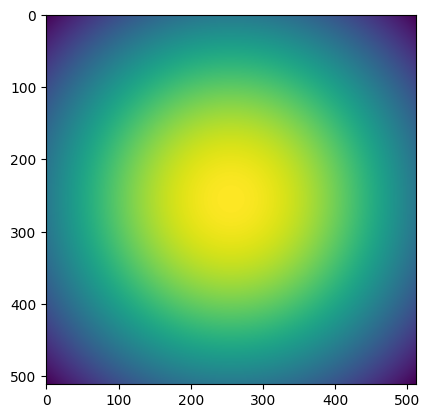

In [58]:
plt.imshow(param.w_kernel)

In [59]:
# im = output['infer']['negative']['field']
# im = param.atlas[src[0]:dst[0], src[1]:dst[1]].copy()
# w = param.weight[src[0]:dst[0], src[1]:dst[1]].copy()
# im /= (w + 1e-3)
# mask = param.var[src[0]:dst[0], src[1]:dst[1]]
im = output['prob_map']
# im = output['thin']
# im = output['infer']['inp_mask']
# im = sigmoid(output['infer']['logit']) ** 2
# im = output['prob_map']  + output['beta']
# mean = np.quantile(im[im > 0], .2)
# print(mean)
# im = output['beta']
# im = output['hard']
# im = scipy.ndimage.binary_fill_holes(im > param.alpha)
# src = param.root
# dst = src + param.patch_size
# im = param.dis_map[src[0]:dst[0], src[1]:dst[1]]
# print(im)
# plt.imshow(np.linalg.norm(im, axis=-1))
plt.imshow(im)
plt.title(im.max())
plt.colorbar()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
# src, dst = param.roi[:2], param.roi[2:]
# image = param.image[src[0]:dst[0], src[1]:dst[1]]
# mask = param.label[src[0]:dst[0], src[1]:dst[1], None] 
# pred = param.b_mask[src[0]:dst[0], src[1]:dst[1], None]
cv2.imwrite("/work/hpc/potato/airc/data/viz/image.jpg", param.image[..., ::-1])
# cv2.imwrite("/work/hpc/potato/airc/data/viz/seg_pred.jpg", pred * 255)
# cv2.imwrite("/work/hpc/potato/airc/data/viz/seg_label.jpg", mask * 255)

In [ ]:
# plt.imshow(cv2.threshold((logit * 255).astype(int).astype(np.uint8), 20, 1, cv2.THRESH_OTSU + cv2.THRESH_BINARY)[1])                                          `
# plt.colorbar()
gain = np.sqrt(np.pi)
std = param.beta.mean() * param.w_kernel.mean() / scipy.ndimage.gaussian_filter(param.weight[src[0]:dst[0], src[1]:dst[1]], 30)
dirac = lambda x, mean, std:  np.exp((x - mean) / (std * 1.44)) / (2.5 * std)
beta = param.beta[src[0]:dst[0], src[1]:dst[1]] / param.weight[src[0]:dst[0], src[1]:dst[1]]

# p_logit = skimage.restoration.denoise_wavelet(logit[..., None], channel_axis=-1, rescale_sigma=True)
p_logit = output['prob_map']
# softmask = dirac(logit ** 1.5, beta, std) * (logit > param.alpha)
# grad = scipy.ndimage.gaussian_laplace(p_logit, sigma=1.)
# grad = (grad / np.abs(grad).max())
softmask = p_logit
s = softmask ** 2
# s = np.interp(softmask, (softmask.min(), softmask.max()), (0, 1))
pseudo_mask = (s > .8).astype(np.uint8)
cand = np.minimum(s * 255, 255).astype(np.uint8)

# softmask = sigmoid(cand)

# softmask[softmask > 255] = 255
clahe = cv2.createCLAHE(clipLimit=2., tileGridSize=(31,31))
cl1 = clahe.apply(cv2.GaussianBlur(cand, (3, 3), 0))
mask = cv2.adaptiveThreshold(cl1, 1, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 91, -15)
pseudo_mask = (cl1 > 130).astype(np.uint8)
# pseudo_mask = cv2.threshold(cl1, 200, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
# most_confidence =
# mask = cv2.threshold(cand.astype(np.uint8), 200, 1, cv2.THRESH_OTSU + cv2.THRESH_BINARY)[1]
# radius = 15
# footprint = skimage.morphology.disk(radius)
# local_otsu = skimage.filters.rank.otsu(softmask.astype(np.uint8), footprint)
# mask = (softmask > local_otsu).astype(np.uint8)
# mask = prune(mask, min_size=50)
# mask = np.maximum(mask, pseudo_mask)
# mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones([3, 3], dtype=np.uint8), 2)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[8, 6])
im = ax1.imshow(image)
ax1.set_title("Original Logit")
fig.colorbar(im, ax=ax1)

im=ax2.imshow(cl1)
ax2.set_title("Softmask")
fig.colorbar(im, ax=ax2)

im=ax3.imshow(pseudo_mask)
ax3.set_title("Hard Thresholding")
fig.colorbar(im, ax=ax3)

ax4.imshow(mask)
ax4.set_title("Adaptive Thresholding")
plt.show()

In [ ]:
index = np.argmax(softmask)
pos = np.unravel_index(index, softmask.shape, order='F')
print(pos)

In [ ]:
pts = output['infer']['pts']
plt.imshow(output['infer']['input'])
plt.axis('off')
# plt.scatter(pts[:, 0], pts[:, 1], marker='s', s=5, color=(1, 0, 1))
# plt.colorbar()

In [ ]:
output['infer']['negative'].keys()

In [ ]:
x, y = param.root
plt.imshow(param.image[x:x+512, y:y+512])

In [ ]:
cnts, _ = cv2.findContours(p_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
output = cv2.drawContours(image.copy(), cnts, -1, (0,0,255), 3)
plt.imshow(output[..., ::-1])
plt.axis('off')

In [ ]:

# Red for FP, Blue for FN
# fp = pred * (1 - mask) * np.array([0, 0, .2])[None, None, :]
# fn = mask * (1 - pred)  * np.array([.2, 0, 0])[None, None, :]
# masks = pred
# save_img = image * (1 - masks) + 255 * masks


In [ ]:
# print(pred.shape, image.shape)
cv2.imwrite("/work/hpc/potato/airc/data/viz/image.jpg", image[..., ::-1])

In [ ]:
# param.b_mask[src[0]:dst[0], src[1]:dst[1]] = mask

In [ ]:
hsv_image = cv2.cvtColor(param.image, cv2.COLOR_BGR2HSV)
unsharp = cv2.bilateralFilter(hsv_image,9,50,75)
hsv_image = 2 * hsv_image - unsharp 

In [ ]:
# mask = logit > 0.2
# kernel = np.ones([3, 3], dtype=np.uint8)
# skeleton = skimage.morphology.skeletonize(param.label)
# plt.imshow(param.image[..., ::-1])
# plt.imshow(image[..., ::-1])
plt.imshow(hsv_image[src[0]:dst[0], src[1]:dst[1], 2])
# keypoints = np.argmax(logit, axis=1)
# print(keypoints.shape,  logit.shape, logit.max())
# pts = [logit[i, pt] for i, pt in enumerate(keypoints)]
# chosen = np.argmax(pts)
# pt = keypoints[chosen]
# print((chosen, pt) + src, logit[chosen, pt], src)
# plt.colorbar()
# plt.imshow(hsv_image[src[0]:dst[0], src[1]:dst[1], 0] )

In [ ]:
param.graph_root = (453, 1488)

In [ ]:
bgr_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)
plt.imshow(bgr_image[src[0]:dst[0], src[1]:dst[1]])

In [ ]:
logit = param.logits / param.weight
param.b_mask = (logit ** 1.5 > param.beta).astype(np.uint8)

In [ ]:
# x = torch.from_numpy(param.a_mask[src[0]:dst[0], src[1]:dst[1]].copy()).float().cuda()
x = torch.from_numpy(logit).float().cuda()
canvas = torch.from_numpy(output['canvas']).float().cuda()
canvas /= canvas.max()
dist = geo.GSF2d(canvas[None, None, :], x[None, None, :], theta=1., v=8, lamb=.8, iter = 4).cpu().numpy()[0, 0]
# plt.imshow(dist > np.quantile(dist[dist > 0], 0.2))
plt.imshow(dist)
plt.colorbar()
plt.title(f"{ np.quantile(dist[dist > dist.min()], 0.2)}")

In [ ]:
# plt.imshow(skimage.morphology.skeletonize(output['possible']))

src, dst = param.root, param.root + param.patch_size
image = param.image[src[0]:dst[0], src[1]:dst[1]]
logit = param.logits[src[0]:dst[0], src[1]:dst[1]] / param.weight[src[0]:dst[0], src[1]:dst[1]]
# Plotting
plot = image[:, :, ::-1] * (1- logit[..., None]) / 255 + logit[..., None]
plot = plot * (1 - param.b_mask[src[0]:dst[0], src[1]:dst[1]][..., None])
plt.imshow(plot)
# plt.colorbar()
cv2.imwrite("/work/hpc/potato/airc/data/viz/closed.jpg", (np.repeat(output['thin'][:, :, None] / output['thin'].max(), 3, axis=-1) * 255).astype(int).astype(np.uint8))
branches = [np.array(branch) for branch in output['branches']]
prompt = output['infer']['prompt'] - param.root
annotation = output['infer']['pts']
a_label = output['infer']['label'][:, None]
color = [0, 0, 1, 0.5] * a_label + [1, 0, 0, 0.5] * (1 - a_label)
plt.title(f"Score: {output['infer']['score']}")
plt.scatter(annotation[:, 0], annotation[:, 1], s=50, c=color, marker='*')
plt.scatter(prompt[1], prompt[0], s=100, c=[1, 1, 0, 1], marker='X')
# pt = output['infer']['prompt']
# plt.scatter(pt[1], pt[0])
for branch in branches:
    plt.plot(branch[:, 1], branch[:, 0])

In [ ]:
p = 0.98
score = np.quantile(prob_map, p)
prob_map = sigmoid(output['infer']['logit'])
plt.imshow(prob_map > score)
plt.title(f"{p}-quantile {score}")

In [ ]:
param.queue

In [ ]:
dist = param.pos[:, None, :] - param.pos[None, :, :]
loss = np.linalg.norm(dist, axis=2)

In [ ]:
loss

In [ ]:
print(param.pos)

In [ ]:
plt.imshow(logit ** 2)
plt.title(f"Score {output['infer']['score']}")
plt.colorbar()

In [ ]:
plt.imshow(logit > 0.458)

In [ ]:
plt.imshow(logit > param.alpha)

In [ ]:
print(logit.min(), logit.max())

In [ ]:
ret = logit ** 0.3
plt.imshow(image[:, :, ::-1] * (1- ret[..., None]) / 255 + ret[..., None])

plt.scatter(pt[1], pt[0], s=0.5, c=(1, 1, 1))

In [ ]:
output = param.iter()
src, dst = param.root, param.root + param.patch_size
image = param.image[src[0]:dst[0], src[1]:dst[1]]
logit = param.logits[src[0]:dst[0], src[1]:dst[1]] / param.weight[src[0]:dst[0], src[1]:dst[1]]
# Plotting
plot = image[:, :, ::-1] * (1- logit[..., None]) / 255 + logit[..., None]
plot = plot * (1 - param.b_mask[src[0]:dst[0], src[1]:dst[1]][..., None])
plt.imshow(plot)
# plt.colorbar()
cv2.imwrite("/work/hpc/potato/airc/data/viz/closed.jpg", (np.repeat(output['thin'][:, :, None] / output['thin'].max(), 3, axis=-1) * 255).astype(int).astype(np.uint8))
branches = [np.array(branch) for branch in output['branches']]
pt = output['infer']['prompt'] - param.root
plt.scatter(pt[1], pt[0])
for branch in branches: 
    print(branch.shape[0])
    plt.plot(branch[:, 1], branch[:, 0])

In [ ]:
plt.imshow(mask)
plt.title(f"Score: {score}")

In [ ]:
prob = sigmoid(logit)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
possible = cv2.morphologyEx(np.where(prob > param.alpha, 1, 0).astype(int).astype(np.uint8), cv2.MORPH_CLOSE, kernel, 1)
possible = scipy.ndimage.binary_fill_holes(possible)
possible = getLargestCC(possible).astype(int).astype(np.uint8)
plt.imshow(possible)

In [ ]:
thin, thin_w = morpholgy_thinning(possible, return_weight=True)

In [ ]:
plt.imshow(thin_w * (thin_w < thin_w.max() * 0.75))
plt.title(f"Max:{thin_w.max()} ")
plt.colorbar()

In [ ]:
cv2.getStructuringElement(cv2.MORPH_CROSS, (5, 5))
stable = ((thin_w > 0) & (thin_w < thin_w.max() * 0.75)).astype(int).astype(np.uint8)
closed = cv2.morphologyEx(stable, cv2.MORPH_DILATE, kernel, 1)
cv2.imwrite("/work/hpc/potato/airc/data/viz/closed.jpg", np.repeat(closed[:, :, None], 3, axis=-1) * 255)
plt.imshow(closed)

In [ ]:
skeleton = skimage.morphology.skeletonize(closed)
plt.imshow(skeleton)
main_branch = getLargestCC(skeleton).astype(int).astype(np.uint8)
plt.imshow(main_branch)

In [ ]:
w_map = (main_branch * prob) / score
w_map[mask * main_branch == 1] = 1
cv2.imwrite("/work/hpc/potato/airc/data/viz/output.jpg", (np.repeat(w_map[:, :, None], 3, axis=2) * 255).astype(int).astype(np.uint8))
plt.imshow(w_map)
plt.colorbar()

Logit map is same shape to mask prompt, which is half the size of image input

In [ ]:
# Always start at stable mask
w_pts = np.array(np.where(w_map == 1)).T
print(w_pts.shape)
dist = np.linalg.norm(w_pts - res['pts'][-1] / 2, axis=1)
nn = w_pts[np.argmin(dist)]
print(nn, res['pts'][-1] / 2)

In [ ]:
dfs_res = dfs_tree(w_map.copy(), res['inp_mask'], tuple(nn), alpha=0.01, thresh=0.8)

In [ ]:
path, branches = longest_path_branching(dfs_res['dfs_tree'], tuple(nn))

In [ ]:
path = np.array(path)
branches = [np.array(branch) for branch in branches]

In [ ]:
leaves = np.array(list(dfs_res['leaves']))
cost_map = dfs_res['cost']
cost_map[cost_map > 100] = 0
plt.plot(path[:, 1], path[:, 0])
for branch in branches: 
    plt.plot(branch[:, 1], branch[:, 0])
plt.imshow(cost_map ** 0.3)
plt.scatter(leaves[:, 1], leaves[:, 0], s=0.2)
plt.colorbar()

In [ ]:
accepted_branch = [branches[i] for i in range(len(branches)) if len(branches[i]) > 10]

In [ ]:
accepted_branch

In [ ]:
len(accepted_branch[0])